<!-- Simon-Style -->
<p style="font-size:19px; text-align:left; margin-top:    15px;"><i>German Association of Actuaries (DAV) — Working Group "Explainable Artificial Intelligence"</i></p>
<p style="font-size:25px; text-align:left; margin-bottom: 15px"><b>Use Case SOA GLTD Experience Study:<br>    
SHAP - Feature Importance</b></p>
<p style="font-size:19px; text-align:left; margin-bottom: 15px; margin-bottom: 15px">Corinna Walk (<a href="mailto:corinna.walk@viadico.com">corinna.walk@viadico.com</a>)

In this notebook, we aim to analyze feature importance using a dataset provided by the Society of Actuaries (SOA) from the GLTD Experience Study. By focusing on the explainability of machine learning models, we seek to understand the factors that influence claim reactivation. This analysis can provide valuable insights for insurance companies to more effectively manage and predict claim reactivations, as well as estimate mortality rates.

To achieve this, we will employ the Shapley Additive Explanations (SHAP) method, which offers a robust approach for interpreting the predictions of machine learning models. SHAP values help identify the contribution of each feature to the model's output, providing a clear and consistent measure of feature importance.

The models used in this notebook are based on the findings and methodologies developed in the other notebooks. These notebooks lay the groundwork for data preprocessing, feature engineering, and initial model selection, which are crucial steps leading to the analysis performed here.



<h1 style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px; padding-left: 14px;">Content</h1>

The notebook is structured into the following sections:

[Preparation](#Prep) <br>
[Model Fitting](#fit)<br>
[Shapley Values](#SHAP)<br>
[Conclusion](#Conclusion)<br>

<div style="height: 3px; background-color: black; width: 100%;"></div>

<a id="Prep"></a>
<h1 style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px; padding-left: 14px;">Preparation</h1>

In the original data set, there are many columns and numerous categorical features with multiple levels. To calculate in this setting the Shapley Values, it takes pretty long. Therefore, we rely on the findings from the other notebooks and reduce the dataset to the following attributes:

* Diagnosis_Category
* OwnOccToAnyTransition
* Gender
* Integration_with_STD
* Original_Social_Security_Award_Status
* Updated_Social_Security_Award_Status
* Duration_Month
* Attained_Age

In [3]:
## Import necessary libraries
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GroupShuffleSplit, cross_val_score
from sklearn.metrics import log_loss

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from glum import GeneralizedLinearRegressor

import shap

Line 8 below contains the path to the data variable, which is created by the prior notebooks "data_initialisation" and "data_preparation". It has to be modified according to your local set up.

In [4]:
## Set a random seed
sq = np.random.SeedSequence()
seed_store = sq.entropy
print('seed = {}'.format(seed_store))
rng = np.random.default_rng(seed=sq)

# Load the prepared dataset 
datadir = "./"
fn_in = "gltd09_13work.feather"
gltd = pd.read_feather(datadir + fn_in)
gltd = gltd.reset_index(drop=True)

# classification of inputs
col_cat = {'Elimination_Period', 'Diagnosis_Category', 
            'OwnOccToAnyTransition', 'Gender','Mental_and_Nervous_Period', 
           "M_N_Limit_Transition", 'Industry', 'Taxability_of_Benefits', 
           'Integration_with_STD','Residence_State', 'COLA_Indicator', 
           'Benefit_Max_Limit_Proxy', 'Original_Social_Security_Award_Status',
           'Updated_Social_Security_Award_Status'}

col_num = {'Duration_Month', 'Age_at_Disability', 'Attained_Age', 
           'Gross_Indexed_Benefit_Amount', 'Indexed_Monthly_Salary', 
           'Case_Size','Replacement_Ratio', 'Month_of_Study'}

# set global exclusions to run with a reduced set of variables
ex_cat = set()
ex_cat = {'Elimination_Period', 'Mental_and_Nervous_Period', 
           "M_N_Limit_Transition", 'Industry', 'Taxability_of_Benefits', 
           'Residence_State', 'COLA_Indicator', 
           'Benefit_Max_Limit_Proxy'}
col_cat = col_cat - ex_cat
ex_num = set()
ex_num =  { 'Age_at_Disability',
           'Gross_Indexed_Benefit_Amount', 'Indexed_Monthly_Salary', 
           'Case_Size','Replacement_Ratio', 'Month_of_Study'}
col_num = col_num - ex_num
# sanity check
gltd.drop(list(ex_cat | ex_num), axis=1, inplace=True)
assert (set(gltd.columns.values) == col_num | col_cat | {"Actual_Recoveries", "Study_ID"})

seed = 3227407841921006213334719100231370450


In [5]:
# selection of total size of dataset as a percentage of all available Study_Ids
pct = 0.3
if pct < 1:
    id_uq = gltd["Study_ID"].unique()

    nidsel = np.floor(pct * id_uq.size).astype(int)
    id_sel = rng.choice(id_uq, nidsel, replace=False)
    flg_sel = gltd["Study_ID"].isin(id_sel)
else:
    flg_sel = np.ones(gltd.shape[0], dtype=bool)

In [6]:
# Prepare designs
id = gltd.loc[flg_sel, "Study_ID"]
destbl = gltd[flg_sel].drop(["Study_ID"], axis=1)


# Convert the categorical features to numbers (for SHAP)
cat_columns = destbl.select_dtypes(['category']).columns
destbl[cat_columns] = destbl[cat_columns].apply(lambda x: x.cat.codes)

# create ohe DataFrame used for trees
ct = ColumnTransformer(
    [("", OneHotEncoder(drop="first", sparse_output=False, dtype=int),
                        list(col_cat)),
    ("drop", "drop", "Actual_Recoveries")],
    remainder="passthrough", verbose_feature_names_out=True)

destbl_ohe = pd.DataFrame(
    ct.fit_transform(destbl), columns=ct.get_feature_names_out())

# Set up CV which respects Study_ID groups
gss = GroupShuffleSplit(train_size=0.7, test_size=0.3,
                        random_state=rng.integers(low=0, high=1000))
trainidx, testidx = next(gss.split(destbl,groups=id))

# note that data still contains Actual_Recoveries
xtrain, xtest = destbl.iloc[trainidx], destbl.iloc[testidx] 

<div style="height: 3px; background-color: black; width: 100%;"></div>

<a id="Fit"></a>
<h1 style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px; padding-left: 14px;">Model Fitting</h1>

These models are replicated from the notebooks rep_glm.ipynb, rep_tree.ipynb, rep_glm.ipynb. The parameters have been adopted, and the focus in this notebook is solely on explainability with Shapley Values.

We consider the 3 models:
* General Linear Model (GLM)
* Decision Tree
* Gradient Boosting


**General Lineral Model (GLM)**

In [9]:
# GLM
ttlist = (list(col_cat)
          + ["bs(" + var + ", df=5, degree=3, extrapolation='extend')" for var in col_num] )
fml = "Actual_Recoveries ~ " + "+".join(ttlist)
mdGLM = GeneralizedLinearRegressor(
            l1_ratio=0.0,
            alpha=1e-6,
            family="binomial", 
            link="logit",
            fit_intercept=True,
            drop_first=True,
            formula = fml
        )
        
mdGLM.fit(xtrain)
phat = mdGLM.predict(xtest)
ergtbl = pd.concat([xtest.reset_index(drop=True), pd.DataFrame({"phat_GLM": phat})], axis=1)

**Decision Tree**

In [10]:
# Tree
xtrain_ohe, xtest_ohe = destbl_ohe.iloc[trainidx], destbl_ohe.iloc[testidx]
ytrain = destbl.iloc[trainidx, destbl.columns.get_loc('Actual_Recoveries')]
ytest = destbl.iloc[testidx, destbl.columns.get_loc('Actual_Recoveries')]

mdTree = DecisionTreeClassifier(
            random_state=rng.integers(low=0, high=1000),
            max_depth=7, 
            criterion="log_loss"
            )
        
mdTree.fit(xtrain_ohe, ytrain)
phat = mdTree.predict_proba(xtest_ohe)[:,1]
ergtbl = pd.concat([ergtbl, pd.DataFrame({"phat_Tree": phat})], axis=1)

**Gradient Boosting**

In [11]:
# GBT
mdBoost = HistGradientBoostingClassifier(
        interaction_cst = None,
        categorical_features="from_dtype",
        max_iter=1000,
        learning_rate=0.025,
        max_leaf_nodes=100,
        random_state=rng.integers(low=0, high=1000))

mdBoost.fit(xtrain.drop("Actual_Recoveries", axis=1), 
       xtrain["Actual_Recoveries"])
phat = mdBoost.predict_proba(xtest.drop("Actual_Recoveries", axis=1))[:,1]
ergtbl = pd.concat([ergtbl, pd.DataFrame({"phat_GBT": phat})], axis=1)

Just similiar to the other notebooks, we ensure that the models accuracy is good enough to make a more detailed analysis with the SHAP values.

In [12]:
#Evaluate the models on the testing data

nm_md = ["GLM", "GBT", "Tree"]

restbl = pd.DataFrame(
    {"model": nm_md,
     "loss": [log_loss(ergtbl["Actual_Recoveries"], ergtbl["phat_GLM"]),
    log_loss(ergtbl["Actual_Recoveries"], ergtbl["phat_GBT"]),
    log_loss(ergtbl["Actual_Recoveries"], ergtbl["phat_Tree"])]}
)
restbl

,model,loss
0,GLM,0.058965
1,GBT,0.053910
2,Tree,0.056568


As we can see in this tabular, the gradient boosting model performs best.

<div style="height: 3px; background-color: black; width: 100%;"></div>

<a id="SHAP"></a>
<h1 style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px; padding-left: 14px;">Shapley Values</h1>

In this section, we calculate the Shapley Values for each model and plot the feature importance.
Note that especially the Explainer for the GLM may require a considerable amount of time to execute, so you can limit the dataset to less than 100000, i.e. 10000 data points.

In [13]:
# To improve performance, limit the data and create a sample
X_sample = shap.utils.sample(xtrain, 1000).drop('Actual_Recoveries', axis = 1)
X_sampleOHE = shap.utils.sample(xtrain_ohe, 1000) 

**GLM**

In [14]:
# Initialize the SHAP explainer with the trained model
explainer = shap.Explainer(mdGLM.predict, X_sample)
# Calculate the SHAP values
shap_values = explainer(X_sample)

ExactExplainer explainer: 1001it [02:24,  6.58it/s]                                                                    


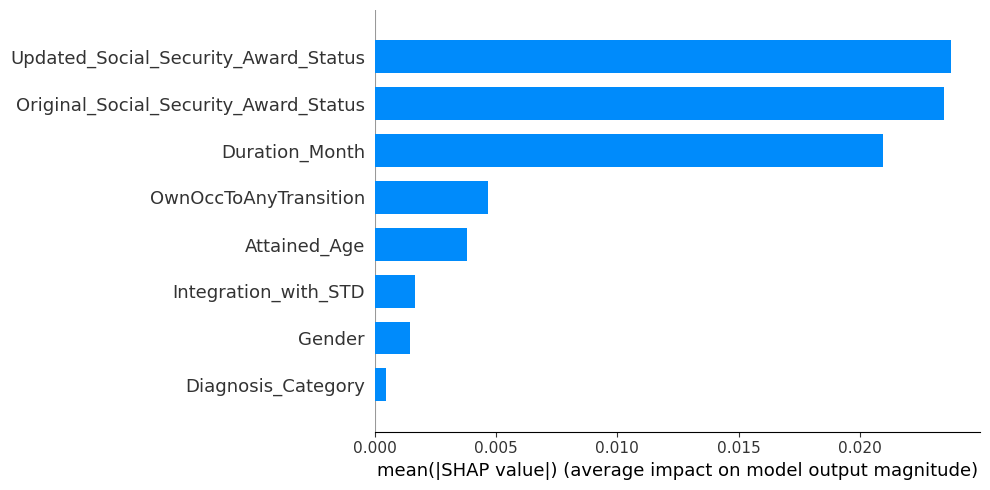

In [15]:
# Plot the summary plot to visualize feature importance
shap.summary_plot(shap_values,X_sample,feature_names=X_sample.columns, plot_type = 'bar',plot_size=(10,5), max_display = 10)

**Decision Tree**

In [34]:
# Initialize the SHAP explainer with the trained model
# TreeExplainer is suitable for tree-based models
exp_shap_tree = shap.TreeExplainer(mdTree, X_sampleOHE)
# Calculate the SHAP values
shap_values = exp_shap_tree.shap_values(X_sampleOHE)

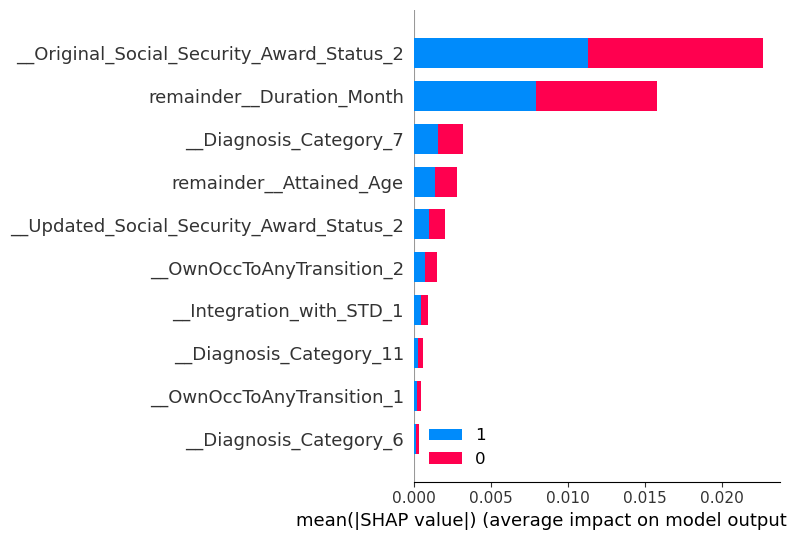

In [39]:
shap_value_summary = exp_shap_tree.shap_values(X_sampleOHE)
ensured_list_shap_values = [shap_value_summary[:,:,i] for i in range(shap_value_summary.shape[2])]
shap.summary_plot(ensured_list_shap_values, feature_names=X_sampleOHE.columns, max_display = 10,  class_names = mdTree.classes_)

For the decision tree model, one-hot encoding was essential, as the SHAP package does not support pipelines. To circumvent a complex aggregation of the explanations, we directly plotted the one-hot encoded features. The plot still allows for the identification of the original categorical feature sequences.
It is important to note that this approach is not entirely precise, as the first column of each categorical variable was dropped during the one-hot encoding process. However, after summing the columns, this marginal effect should be minimal.

**Gradient Boosting**

In [19]:
# Initialize the SHAP explainer with the trained model
# TreeExplainer is suitable for tree-based models
exp_shap_boost = shap.TreeExplainer(mdBoost)
# Calculate the SHAP values
shap_values = exp_shap_boost.shap_values(X_sample)

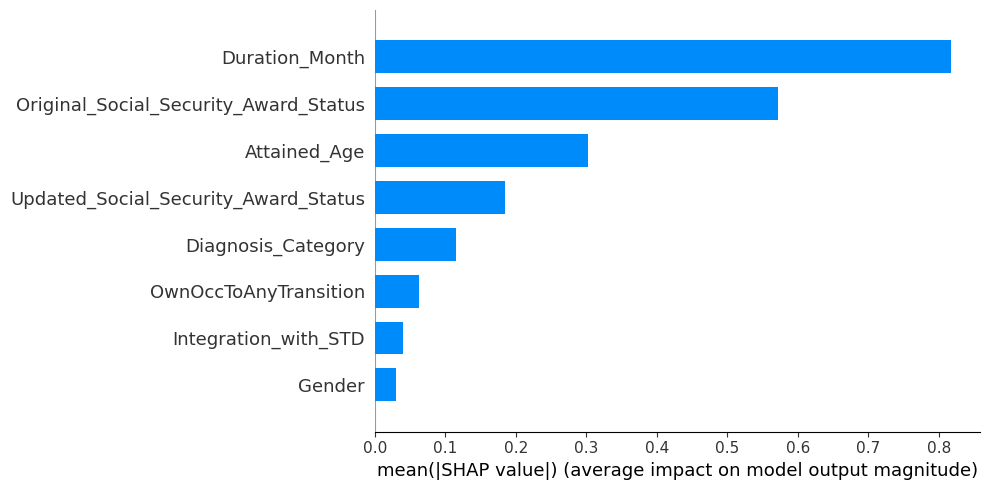

In [20]:
# Plot the summary plot to visualize feature importance
shap.summary_plot(shap_values,X_sample,feature_names=X_sample.columns, plot_type = 'bar',plot_size=(10,5), max_display = 10)

<div style="height: 3px; background-color: black; width: 100%;"></div>

<a id="Conclusion"></a>
<h1 style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px; padding-left: 14px;">Conclusion</h1>

In this notebook, we explored Shapley values as a method for model interpretability. Despite the long computation times required to calculate Shapley values, our analysis revealed almost consistent results across all three models evaluated. 
It should be noted that the top three variables differ slightly across the three models. For the GLM and the Decision Tree, the most important feature is `Original_Social_Security_Award_Status`, whereas for the Boosting model, the most important feature is `Duration_Month`. Nonetheless, this feature is also among the top three variables in both the GLM and Decision Tree models.

This uniformity in results enhances the credibility of the Shapley values approach and supports its plausibility in providing meaningful insights.

The findings were in line with domain knowledge, validating the practical relevance of the Shapley values in a real-world context. Additionally, even when considering all available variables, the results remained similar, demonstrating the robustness of Shapley values in handling comprehensive datasets.